In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import functools
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [203]:
def read_pickle(*names):
    for name in names:
        df = pd.read_pickle(f"D:/proj/phd/agge/src/experiment/ipinyou/onehot/{name}.pickle")
        if name=="result__10" or name == "results__3" or name == "results__4":
            yield df[(df.algorithm != "MLP-v0") & (df.algorithm != "DeepWide")]
        elif name=='result__10a_up_to_63' or name=="result__10a_from_64" or name=="result__10c":
            yield df[df.algorithm != "DeepWideV2"]
        else:
            yield df

def read_data(*names):
    return functools.reduce(lambda df0, df1: df0.append(df1), read_pickle(*names))

# df = read_data("result__10", "results__3", "results__4", 
#                "result__10a_up_to_63", "result__10a_from_64", "result__10b", "result__10c")
df = read_data( "conj_5_4", "conj_4", "conj_3", "conj_0", "conj_1", "conj_2")
df = df.explode("value")

In [204]:
# unify LR parameter
df.loc[df.C.notna(), 'alpha'] = df[df.C.notna()].C
# bins removed from OH
df.loc[df.encoding == 'oh', 'bins'] = "N/A"

# df = df[(df.subject=='2261') | (df.subject=='2821') | (df.subject=='2997')]
df.shape

(1548, 13)

In [205]:
df.columns

Index(['measure_type', 'value', 'algorithm', 'subject', 'encoding', 'features',
       'conj', 'max_iter', 'verbose', 'solver', 'C', 'bins', 'alpha'],
      dtype='object')

In [206]:
df.measure_type.unique()

array(['auc_train', 'auc_test', 'delta'], dtype=object)

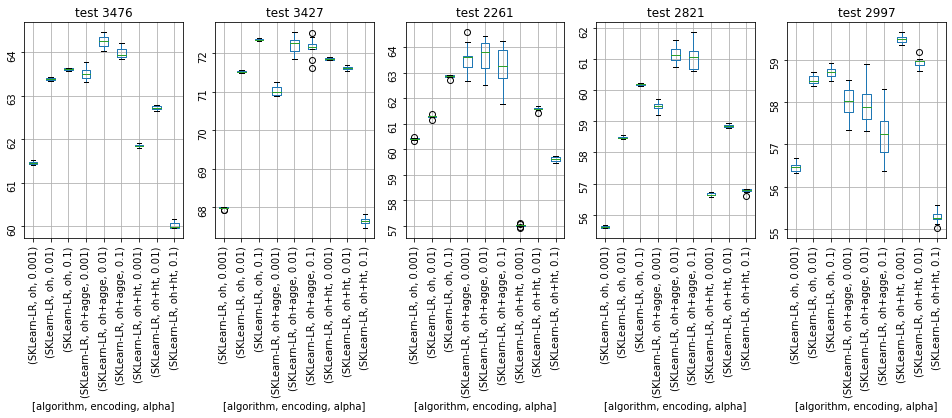

In [207]:
# select best alpha
fig, axs = plt.subplots(ncols=len(df.subject.unique()), nrows=1, figsize=(16, 4))

sample = df
# sample = sample[sample.encoding!="oh"]
sample = sample[sample.encoding!="agge"]
# sample = sample[sample.alpha=="0.01"]
for idx, subject in enumerate(df.subject.unique()):
    sample[((sample.measure_type == "auc_test") ) # | (sample.measure_type == "auc_best_model_test")
           & (sample.subject == subject)]\
    .boxplot(by=["algorithm",  'encoding', 'alpha'], column="value", ax=axs[idx])
    
    axs[idx].set_title("test " + subject)
#     df[(df.measure_type == "auc_train") & (df.subject == subject)].boxplot(by="algorithm", column="value")
#     plt.title("train " + subject)
    axs[idx].tick_params(rotation=90)
fig.suptitle('', fontsize=16)

plt.show()

D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison f

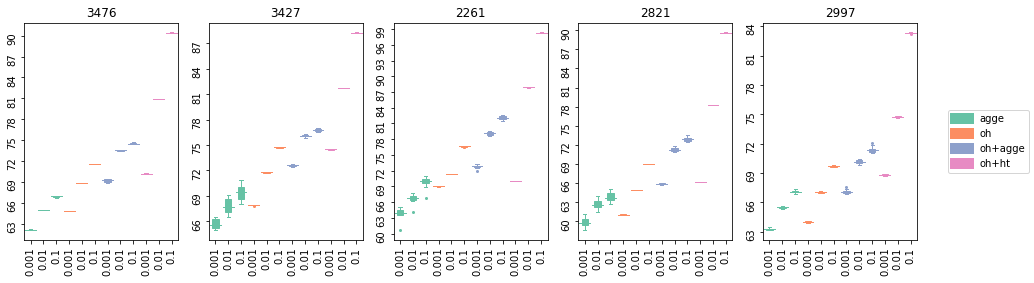

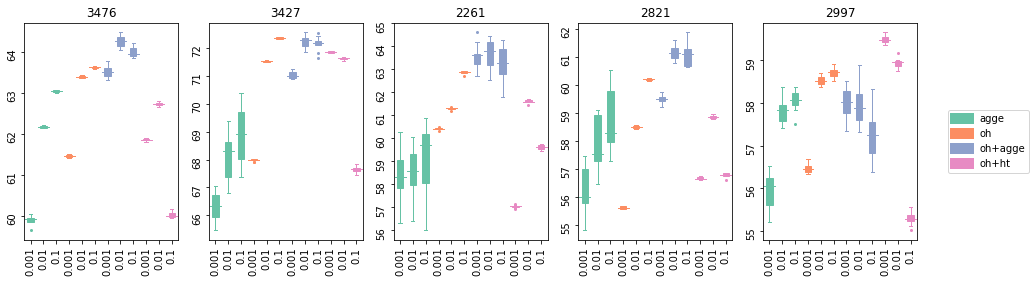

In [208]:
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib.patches import Rectangle, PathPatch
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as ticker



def plot_sample(sample, multialpha=True, step=1):
    fig, axs = plt.subplots(ncols=len(sample.subject.unique()), nrows=1, figsize=(16, 4))
    
    cmap = plt.get_cmap("Set2")

    for idx, subject in enumerate(sample.subject.unique()): # palette="deep",
        axs[idx].set_title(subject)

    #     ax = sns.boxplot(x="encoding", y="value", hue="alpha", data=sample[sample.subject == subject], ax=axs[idx],
    #                      showfliers = True, palette="deep", width=0.9)
        dat = sample[sample.subject == subject]
    #     dat.boxplot(by=["encoding", 'alpha'], column="value", ax=axs[idx])
        alphas = dat.alpha.unique().tolist()
        alphas = sorted(alphas)

        def data(df):
            for encoding in df.encoding.unique():
                for alpha in alphas:
                    ret = df[(df.alpha == alpha) & (df.encoding == encoding)].value
                    if ret.shape[0] > 0:
                        yield ret, alpha, encoding
                    else:
                        print(f'skip {alpha}, {encoding}, {ret}')
        
        _nums = []
        _alphas = []
        _encodings = []
        for n, a, e in data(dat):
            _nums.append(n)
            _alphas.append(a)
            _encodings.append(e)
#         print(_alphas, _encodings, _nums)
        bplot = axs[idx].boxplot(_nums,
                                 vert=True,  
                                 patch_artist=True, 
                                 labels=_alphas,
                                 medianprops = dict(linestyle='-', linewidth=1, color='black'))
        colors = np.repeat([cmap(enc_id) for enc_id in range(len(dat.encoding.unique()))], 
                           len(alphas) if multialpha else 1, axis=0)

    #     colors = ['pink', 'lightblue', 'lightgreen']
#         print({k:len(bplot[k]) for k in bplot.keys()})
        def set_color(o, color):
            if hasattr(o, 'set_facecolor'):
                o.set_facecolor(color)
            if hasattr(o, 'get_color'):
                o.set_color(color)
            if hasattr(o, 'get_edgecolor'):
                o.set_edgecolor(color)   
            if hasattr(o, 'set_markeredgecolor'):
                o.set_markeredgecolor(color)   
            if hasattr(o, 'set_markerfacecolor'):
                o.set_markerfacecolor(color)   


        for o, color in zip(bplot['boxes'], colors.tolist()):
            set_color(o, color)

        for o, color in zip(bplot['fliers'], colors.tolist()):
            set_color(o, color)
            o.set_markersize(2)

        for o, color in zip(bplot['whiskers'], np.repeat(colors.tolist(), 2, axis=0)):
            set_color(o, color)

        for o, color in zip(bplot['caps'], np.repeat(colors.tolist(), 2, axis=0)):
            set_color(o, color)
            
        for median, color in zip(bplot['medians'], colors.tolist()):
#             median.set(color='k', linewidth=1,)
            x,y = median.get_data()
            xn = (x-(x.sum()/2.))*0.5+(x.sum()/2.)
            axs[idx].plot([xn - 0.3, xn + 0.3], [y, y], color=color, zorder=4, antialiased=False, linewidth=1)

        axs[idx].tick_params(rotation=90)
        axs[idx].yaxis.set_major_locator(ticker.MultipleLocator(step))
    import matplotlib.patches as mpatches
    custom_lines = [ mpatches.Patch([0], [0], color=cmap(0), lw=4),
                     mpatches.Patch([0], [0], color=cmap(1), lw=4),
                     mpatches.Patch([0], [0], color=cmap(2), lw=4),
                     mpatches.Patch([0], [0], color=cmap(3), lw=4)]

    fig.legend(handles=custom_lines, labels=sample.encoding.unique().tolist(), loc='center right')
# sample = sample[sample.encoding!="oh"]
# sample = sample[sample.encoding!="agge"]
sample = df
sample.alpha = sample.alpha.astype('float')
sample = sample.sort_values(['encoding', 'alpha']).reset_index()

# sample = sample[((sample.measure_type == "auc_test"))]   
plot_sample(sample[((sample.measure_type == "auc_train"))], step=3)
plot_sample(sample[((sample.measure_type == "auc_test"))])

# plot_sample(sample[sample.alpha==0.01])


In [187]:
df.shape

(1536, 13)

In [192]:
sample = sample[((sample.measure_type == "auc_test"))]
mmx = sample[['algorithm', 'alpha', 'value', 'encoding', 'subject']]\
.groupby(['algorithm', 'alpha', 'encoding', 'subject']).median().groupby(['algorithm', 'encoding', 'subject']).idxmax()
print(mmx)
max_sample = None
for maxed in mmx.reset_index().value:
    _df = sample[(sample.algorithm == maxed[0]) & 
                 (sample.alpha == maxed[1]) & 
                 (sample.encoding == maxed[2]) & 
                 (sample.subject == maxed[3])].copy()
    max_sample = _df if max_sample is None else _df.append(max_sample, ignore_index=True)
max_sample = max_sample.sort_values(['encoding', 'alpha']).reset_index()


                                                          value
algorithm  encoding subject                                    
SKLearn-LR agge     2261          (SKLearn-LR, 0.1, agge, 2261)
                    2821          (SKLearn-LR, 0.1, agge, 2821)
                    2997          (SKLearn-LR, 0.1, agge, 2997)
                    3427          (SKLearn-LR, 0.1, agge, 3427)
                    3476          (SKLearn-LR, 0.1, agge, 3476)
           oh       2261            (SKLearn-LR, 0.1, oh, 2261)
                    2821            (SKLearn-LR, 0.1, oh, 2821)
                    2997            (SKLearn-LR, 0.1, oh, 2997)
                    3427            (SKLearn-LR, 0.1, oh, 3427)
                    3476            (SKLearn-LR, 0.1, oh, 3476)
           oh+agge  2261      (SKLearn-LR, 0.01, oh+agge, 2261)
                    2821      (SKLearn-LR, 0.01, oh+agge, 2821)
                    2997     (SKLearn-LR, 0.001, oh+agge, 2997)
                    3427      (SKLearn-L

skip 0.01, agge, Series([], Name: value, dtype: object)
skip 0.01, oh, Series([], Name: value, dtype: object)
skip 0.1, oh+agge, Series([], Name: value, dtype: object)
skip 0.1, oh+ht, Series([], Name: value, dtype: object)
skip 0.001, agge, Series([], Name: value, dtype: object)
skip 0.01, agge, Series([], Name: value, dtype: object)
skip 0.001, oh, Series([], Name: value, dtype: object)
skip 0.01, oh, Series([], Name: value, dtype: object)
skip 0.001, oh+agge, Series([], Name: value, dtype: object)
skip 0.1, oh+agge, Series([], Name: value, dtype: object)
skip 0.01, oh+ht, Series([], Name: value, dtype: object)
skip 0.1, oh+ht, Series([], Name: value, dtype: object)
skip 0.001, agge, Series([], Name: value, dtype: object)
skip 0.001, oh, Series([], Name: value, dtype: object)
skip 0.1, oh+agge, Series([], Name: value, dtype: object)
skip 0.1, oh+ht, Series([], Name: value, dtype: object)
skip 0.01, agge, Series([], Name: value, dtype: object)
skip 0.01, oh, Series([], Name: value, dt

D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
D:\app\anaconda\envs\phd-3.9\lib\site-packages\matplotlib\lines.py:1155: FutureWarning: elementwise comparison f

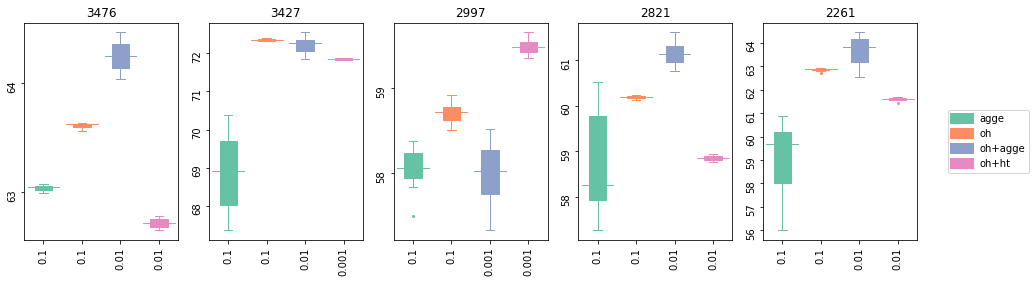

In [193]:
plot_sample(max_sample, multialpha=False)


NameError: name 'alpha' is not defined

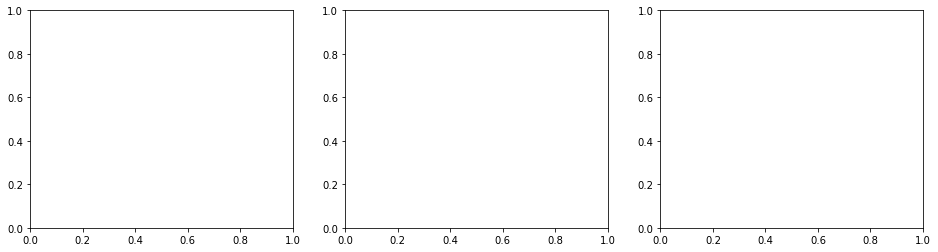

In [153]:
# select best alpha
fig, axs = plt.subplots(ncols=len(df.alpha.unique()), nrows=1, figsize=(16, 4))

sample = df
sample = sample[((sample.measure_type == "auc_test"))]
for idx, subject in enumerate(df.alpha.unique()):
    sample[((sample.measure_type == "auc_test") ) # | (sample.measure_type == "auc_best_model_test")
           & (sample.alpha == alpha)]\
    .boxplot(by=['subject'], column="value", ax=axs[idx])
    axs[idx].set_title("test " + alpha)
#     df[(df.measure_type == "auc_train") & (df.subject == subject)].boxplot(by="algorithm", column="value")
#     plt.title("train " + subject)
#     axs[idx].tick_params(rotation=90)
plt.show()

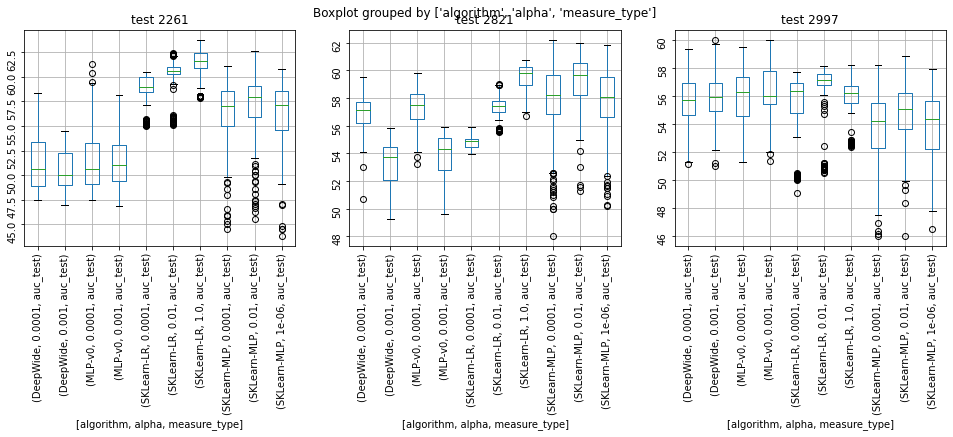

In [136]:
# select best alpha
fig, axs = plt.subplots(ncols=len(df.subject.unique()), nrows=1, figsize=(16, 4))

sample = df

for idx, subject in enumerate(df.subject.unique()):
    sample[((sample.measure_type == "auc_test") ) # | (sample.measure_type == "auc_best_model_test")
           & (sample.subject == subject)]\
    .boxplot(by=["algorithm", 'alpha', 'measure_type'], column="value", ax=axs[idx])
    axs[idx].set_title("test " + subject)
#     df[(df.measure_type == "auc_train") & (df.subject == subject)].boxplot(by="algorithm", column="value")
#     plt.title("train " + subject)
    axs[idx].tick_params(rotation=90)
plt.show()

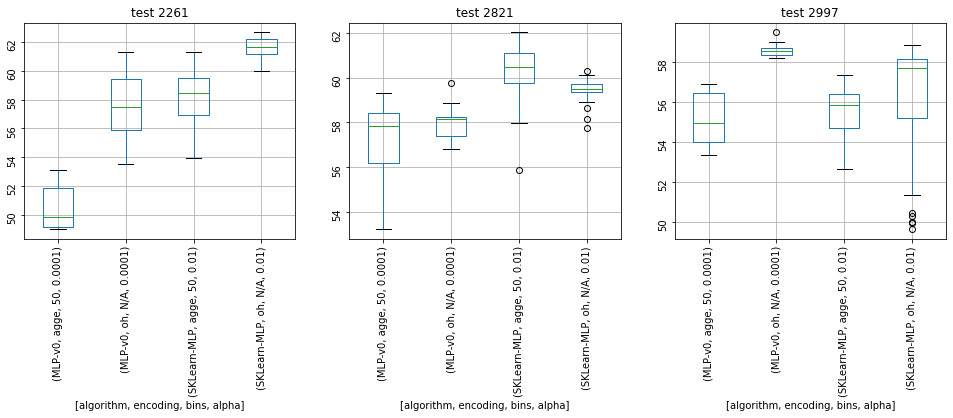

In [144]:

sample = df[
#     ((df.algorithm=="DeepWide") & (df.alpha=="0.0001")) |
    ((df.algorithm=="MLP-v0") & (df.alpha=="0.0001")) |
    ((df.algorithm=="SKLearn-MLP") & (df.alpha=="0.01")) #|
#     ((df.algorithm=="SKLearn-LR") & (df.alpha=="1.0") & ((df.bins=="110") | (df.bins=="N/A")))
]

sample = sample[(sample.bins == '50') | (sample.bins == 'N/A')]
fig, axs = plt.subplots(ncols=len(sample.subject.unique()), nrows=1, figsize=(16, 4))

for idx, subject in enumerate(df.subject.unique()):
    sample[(sample.measure_type == "auc_test") & (sample.subject == subject)]\
    .boxplot(by=["algorithm", 'encoding', 'bins', 'alpha'], column="value", ax=axs[idx])

    axs[idx].set_title("test " + subject)
#     df[(df.measure_type == "auc_train") & (df.subject == subject)].boxplot(by="algorithm", column="value")
#     plt.title("train " + subject)
    axs[idx].tick_params(rotation=90)
    
fig.suptitle('', fontsize=16)

plt.show()

D:\app\anaconda\envs\phd-3.9\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


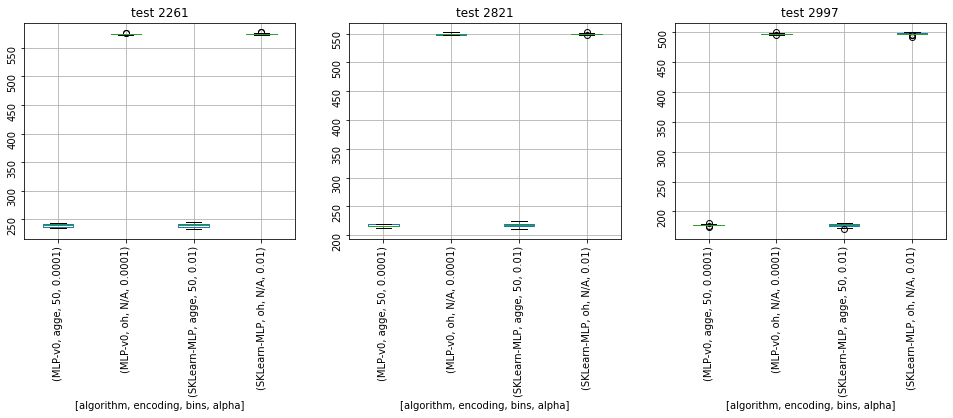

In [147]:
sample = df[
#     ((df.algorithm=="DeepWide") & (df.alpha=="0.0001")) |
    ((df.algorithm=="MLP-v0") & (df.alpha=="0.0001")) |
    ((df.algorithm=="SKLearn-MLP") & (df.alpha=="0.01")) #|
#     ((df.algorithm=="SKLearn-LR") & (df.alpha=="1.0") & ((df.bins=="110") | (df.bins=="N/A")))
]
sample.features = sample.features.astype(int)
sample = sample[(sample.bins == '50') | (sample.bins == 'N/A')]
fig, axs = plt.subplots(ncols=len(sample.subject.unique()), nrows=1, figsize=(16, 4))

for idx, subject in enumerate(df.subject.unique()):
    sample[(sample.measure_type == "auc_test") & (sample.subject == subject)]\
    .boxplot(by=["algorithm", 'encoding', 'bins', 'alpha'], column="features", ax=axs[idx])

    axs[idx].set_title("test " + subject)
#     df[(df.measure_type == "auc_train") & (df.subject == subject)].boxplot(by="algorithm", column="value")
#     plt.title("train " + subject)
    axs[idx].tick_params(rotation=90)
    
fig.suptitle('', fontsize=16)

plt.show()

,measure_type,value,algorithm,subject,encoding,features,hidden_layer_sizes,alpha,batch_size,learning_rate_init,max_iter,validation_fraction,tol,early_stopping,beta_1,beta_2,epsilon,n_iter_no_change,bins,random_state,verbose,solver,C
2146,auc_test,54.639063,SKLearn-MLP,2997,oh,497,"(4, 7)",0.01,1000,0.001,100,0.1,0.0001,NaN,NaN,NaN,NaN,10,N/A,NaN,NaN,NaN,NaN
2146,auc_test,58.497183,SKLearn-MLP,2997,oh,497,"(4, 7)",0.01,1000,0.001,100,0.1,0.0001,NaN,NaN,NaN,NaN,10,N/A,NaN,NaN,NaN,NaN
2146,auc_test,58.86186,SKLearn-MLP,2997,oh,497,"(4, 7)",0.01,1000,0.001,100,0.1,0.0001,NaN,NaN,NaN,NaN,10,N/A,NaN,NaN,NaN,NaN
2146,auc_test,57.945851,SKLearn-MLP,2997,oh,497,"(4, 7)",0.01,1000,0.001,100,0.1,0.0001,NaN,NaN,NaN,NaN,10,N/A,NaN,NaN,NaN,NaN
2146,auc_test,49.962835,SKLearn-MLP,2997,oh,497,"(4, 7)",0.01,1000,0.001,100,0.1,0.0001,NaN,NaN,NaN,NaN,10,N/A,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,auc_test,58.350516,MLP-v0,2997,oh,497,"(32, 4)",0.0001,1000,0.0001,50,0.0,0.0001,True,0.9,0.999,1e-08,5,N/A,NaN,NaN,NaN,NaN
301,auc_test,59.019882,MLP-v0,2997,oh,494,"(32, 4)",0.0001,1000,0.0001,50,0.0,0.0001,True,0.9,0.999,1e-08,5,N/A,NaN,NaN,NaN,NaN
331,auc_test,58.193306,MLP-v0,2997,oh,495,"(32, 4)",0.0001,1000,0.0001,50,0.0,0.0001,True,0.9,0.999,1e-08,5,N/A,NaN,NaN,NaN,NaN
361,auc_test,58.698634,MLP-v0,2997,oh,499,"(32, 4)",0.0001,1000,0.0001,50,0.0,0.0001,True,0.9,0.999,1e-08,5,N/A,NaN,NaN,NaN,NaN


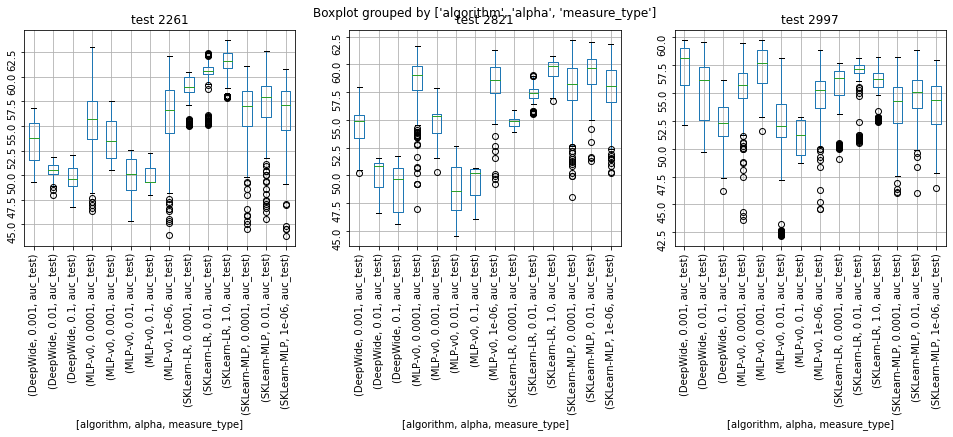

In [62]:
# select best alpha
fig, axs = plt.subplots(ncols=len(df.subject.unique()), nrows=1, figsize=(16, 4))

sample = df

for idx, subject in enumerate(df.subject.unique()):
    sample[((sample.measure_type == "auc_test") ) # | (sample.measure_type == "auc_best_model_test")
           & (sample.subject == subject)]\
    .boxplot(by=["algorithm", 'alpha', 'measure_type'], column="value", ax=axs[idx])
    axs[idx].set_title("test " + subject)
#     df[(df.measure_type == "auc_train") & (df.subject == subject)].boxplot(by="algorithm", column="value")
#     plt.title("train " + subject)
    axs[idx].tick_params(rotation=90)
plt.show()

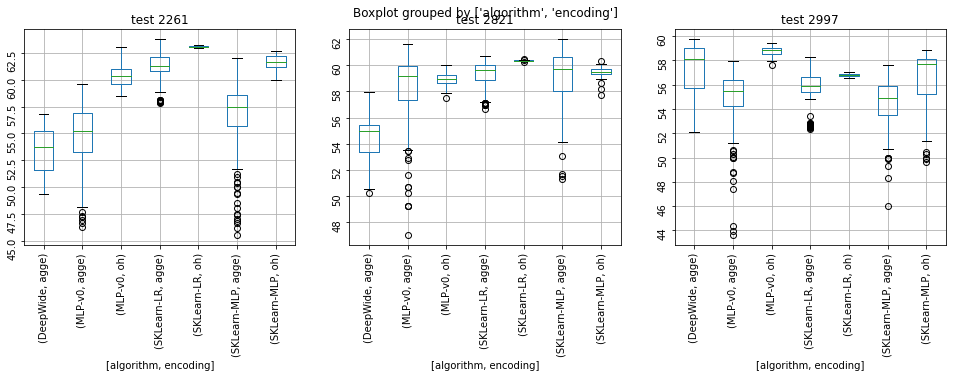

In [65]:
fig, axs = plt.subplots(ncols=len(df.subject.unique()), nrows=1, figsize=(16, 4))

sample = df[
    ((df.algorithm=="DeepWide") & (df.alpha=="0.001")) |
    ((df.algorithm=="MLP-v0") & (df.alpha=="0.0001")) |
    ((df.algorithm=="SKLearn-MLP") & (df.alpha=="0.01")) |
    ((df.algorithm=="SKLearn-LR") & (df.alpha=="1.0"))
]

for idx, subject in enumerate(df.subject.unique()):
    sample[(sample.measure_type == "auc_test") & (sample.subject == subject)]\
    .boxplot(by=["algorithm", 'encoding'], column="value", ax=axs[idx])
    axs[idx].set_title("test " + subject)
#     df[(df.measure_type == "auc_train") & (df.subject == subject)].boxplot(by="algorithm", column="value")
#     plt.title("train " + subject)
    axs[idx].tick_params(rotation=90)
plt.show()

In [64]:
df.columns

Index(['measure_type', 'value', 'algorithm', 'subject', 'encoding', 'features',
       'hidden_layer_sizes', 'alpha', 'batch_size', 'learning_rate_init',
       'max_iter', 'validation_fraction', 'tol', 'early_stopping', 'beta_1',
       'beta_2', 'epsilon', 'n_iter_no_change', 'bins', 'random_state',
       'verbose', 'solver', 'C'],
      dtype='object')